# Introduction

### In this notebook we shall try to discover interestin clustering patters for the users in the dataset. This notebook is divided in 4 sections: 1) clusterizes producers, 2) clusterizes buyers and 3) clusterizes affiliates, and section 4) reports a failed attempt at clustering producers

In [1]:
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns 
import copy
from sklearn.cluster import KMeans

In [2]:
%config Completer.use_jedi = False

In [3]:
sales_df = pd.read_csv("sales_table.csv", delimiter=';')
sales_df = sales_df.drop(0)
sales_df = sales_df.reset_index(drop=True)
sales_df

purchase_id  product_id  affiliate_id  producer_id  buyer_id  \
0            1663958        6640        209372       116238   1200397   
1            1677087        2350        141418         2821   1083764   
2            2017360       35669        618642       618642   1436106   
3            2017379       57998       1164511        70388   1436118   
4            2017382       58329       1261488       221253   1386357   
...              ...         ...           ...          ...       ...   
1599823     14011995      238362       7586641      7586641   5736172   
1599824     14012431       61279        589022       589022    946067   
1599825     14343996      215242       1186145      1186145   6473172   
1599826     14344113      215242       1186145      1186145   6473172   
1599827     14357203      215242       1186145      1186145   6473172   

               purchase_date product_creation_date product_category  \
0        2016-06-26 12:00:00   2011-03-19 15:47:36            Video   
1        2016-06-26 12:00:00   2010-07-05 01:50:15          Podcast   
2        2016-06-26 12:00:00   2012-06-13 02:59:37          Podcast   
3        2016-06-26 12:00:00   2013-05-07 08:51:31          Podcast   
4        2016-06-26 12:00:00   2013-05-12 08:12:06          Podcast   
...                      ...                   ...              ...   
1599823  2016-06-30 23:59:57   2016-06-16 12:10:46    Phisical book   
1599824  2016-06-30 21:40:11   2013-06-15 16:41:06    Phisical book   
1599825  2016-05-13 16:45:42   2016-03-26 17:59:47    Phisical book   
1599826  2016-06-22 14:39:05   2016-03-26 17:59:47    Phisical book   
1599827  2016-04-11 19:37:25   2016-03-26 17:59:47    Phisical book   

               product_niche  purchase_value  affiliate_commission_percentual  \
0        Presentation skills       -0.265302                             50.0   
1           Child psychology       -0.177077                             60.0   
2        Presentation skills       -0.468989                              0.0   
3         Anxiety management       -0.401168                             50.0   
4           Teaching English       -0.452489                             50.0   
...                      ...             ...                              ...   
1599823     Personal finance       -0.345361                              0.0   
1599824     Personal finance       -0.471786                              0.0   
1599825          Negotiation       -0.359158                              0.0   
1599826          Negotiation       -0.359158                              0.0   
1599827          Negotiation       -0.359158                              0.0   

        purchase_device purchase_origin is_origin_page_social_network  
0              Smart TV     Origin ef2b                           0,0  
1              Smart TV     Origin ef2b                           0,0  
2              Smart TV     Origin ef2b                           0,0  
3              Smart TV     Origin ef2b                           0,0  
4              Smart TV     Origin ef2b                           0,0  
...                 ...             ...                           ...  
1599823        eReaders     Origin 3022                           0,0  
1599824        Smart TV     Origin ef2b                           0,0  
1599825        Smart TV     Origin ef2b                           0,0  
1599826        Smart TV     Origin ef2b                           0,0  
1599827          Tablet     Origin 3fcc                           0,0  

[1599828 rows x 14 columns]

# Introduction

### Here we define some functions that will be used through this notebook

In [4]:

#reindexes the dataframe to make it user-centered
def get_user_df(sales_df, user, columns_list):
    
    user_df = sales_df.reindex(columns=user + columns_list)
    user_df = user_df.sort_values(by=user).reset_index(drop=True)
    
    return user_df

#gets a categorical column and converts each of its category types to one-hot representation
def category_to_one_hot(df, column):
    
    category_list = df[column].unique()
    one_hot_df = pd.get_dummies(category_list, prefix='%s_' % column)
    one_hot_df[column] = category_list
    pre_len = len(df)
    df = df.merge(one_hot_df, on=[column], how="left")
    assert len(df) == pre_len
    
    return df, one_hot_df

#converts a list of categorical feature columns in a df to one-hot representation
def get_one_hot_user_df(user_df, columns_list):
    
    for col in columns_list:
        user_df, one_hot_df = category_to_one_hot(df = user_df, column = col )    
        
    return user_df

#function for clusterizing a user-centered df, where different products related to the same user were agreggated (i.e, summed)
#returns centroids and element (user) counts inside each luster
def clusterize(user_df_aggregated, n_clusters):

    X = user_df_aggregated.to_numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    centroids = []
    element_counts_per_cluster = []
    
    for i in range(n_clusters):
        element_counts_cluster_i = (kmeans.labels_==i).sum()
        element_counts_per_cluster.append(element_counts_cluster_i)
        centroids.append(kmeans.cluster_centers_[i])
        
    top_element_counts_idxs = np.argsort(np.array(element_counts_per_cluster)*-1)
    centroids = np.array(centroids)[top_element_counts_idxs]
    element_counts_per_cluster = np.array(element_counts_per_cluster)[top_element_counts_idxs]
    
    return centroids, element_counts_per_cluster

#plots heat map for cluster visualization
def plot_cluster_heatmap(centroids, element_counts_per_cluster, user_df_columns, figsize, heatmap_max_clusters=50, element_name = 'points'):
    
    n_clusters = len(centroids)
    fig, ax = plt.subplots(figsize=figsize)
    element_counts_per_cluster = ['cluster {} with {} {}'.format(i+1, count, element_name) for i, count in enumerate(element_counts_per_cluster)]
    ax.set_title("{} clusters centroids vs features with {} clusters".format(element_name, n_clusters))
    sns.heatmap(centroids[0:min(n_clusters,heatmap_max_clusters)], ax=ax, annot=True, cmap='viridis', 
                xticklabels=user_df_columns, yticklabels=element_counts_per_cluster[0:min(n_clusters,heatmap_max_clusters)], linewidths=1, )

#calls clusterize and plot_cluster_heatmap functions inside a single function
def clusterize_with_heatmap(user_df_aggregated, n_clusters, heatmap_figsize=(25,15), heatmap_max_clusters=50, element_name='points'):
    
    centroids, element_counts_per_cluster = clusterize(user_df_aggregated, n_clusters)
    plot_cluster_heatmap(centroids, element_counts_per_cluster, user_df_columns=user_df_aggregated.columns, figsize=heatmap_figsize, element_name=element_name)
    

# 1) PRODUCER CLUSTER WITH PRODUCT TYPE DISTRIBUTION


## 1.1) Clusters with Product Niche

### We will try to find clustering patterns with different feature choices. Fitstly, we select product_niche. This is a categorical feature, and we need a numerical representation for it in order to cluster it with k-means. So we get a distribution of each product_niche occurance for the same seller, i.e, the df we use to clusterize is a probability distribution for each type of product_niche along each seller row. Because the values are normalized between 0 and 1, we hope this creates a meaningful distance metric for kmeans to operate with. It also filters the information from sales counts, that varies greatly by each user and could dominate the distance metric. The standard approach would be to standardize each feature along the column axis, and this approach was tested, but it didn't work (this is reported in section 4)

In [5]:
#reindexing the dataframe to turn it into producer-centered with "producer_niche" features
user_columns = ['product_niche']
user_df = get_user_df(sales_df, user = ['producer_id'], columns_list=user_columns)

#getting one hot representation for the categorical features
categorical_columns = ['product_niche']
user_df_one_hot= get_one_hot_user_df(user_df, columns_list = categorical_columns)

#summing the categorical features for different products sold by the same producer
user_df_aggregated = user_df_one_hot.groupby([user_df_one_hot.columns[0]]).sum()

#normalizing across columns to get a distribution of categories for each producer
user_df_aggregated = user_df_aggregated.div(user_df_aggregated.sum(axis=1), axis=0)

### df is a probability distribution of "product_niche" along each producer row...

In [6]:
#result is a distribution of sales for each producer, with each row summing 1 across all categories
user_df_aggregated

product_niche__Accounting  product_niche__Anxiety management  \
producer_id                                                                 
3                                  0.0                                0.0   
59                                 0.0                                0.1   
60                                 0.0                                0.0   
80                                 0.0                                0.0   
93                                 0.0                                0.0   
...                                ...                                ...   
7623443                            0.0                                0.0   
7626841                            0.0                                0.0   
7630136                            0.0                                1.0   
7631606                            0.0                                0.0   
9868481                            0.0                                0.0   

             product_niche__Biology  product_niche__Careers  \
producer_id                                                   
3                               0.0                0.000000   
59                              0.0                0.000000   
60                              0.0                0.000000   
80                              0.0                0.922642   
93                              0.0                0.000000   
...                             ...                     ...   
7623443                         0.0                0.000000   
7626841                         0.0                0.000000   
7630136                         0.0                0.000000   
7631606                         0.0                1.000000   
9868481                         0.0                0.000000   

             product_niche__Child psychology  product_niche__Disease  \
producer_id                                                            
3                                        0.0                0.020202   
59                                       0.0                0.000000   
60                                       0.0                0.000000   
80                                       0.0                0.000000   
93                                       0.0                0.000000   
...                                      ...                     ...   
7623443                                  0.0                0.000000   
7626841                                  0.0                0.000000   
7630136                                  0.0                0.000000   
7631606                                  0.0                0.000000   
9868481                                  0.0                0.000000   

             product_niche__Economics  product_niche__Filmmaking  \
producer_id                                                        
3                                 0.0                        0.0   
59                                0.0                        0.0   
60                                0.0                        0.0   
80                                0.0                        0.0   
93                                0.0                        1.0   
...                               ...                        ...   
7623443                           1.0                        0.0   
7626841                           0.0                        0.0   
7630136                           0.0                        0.0   
7631606                           0.0                        0.0   
9868481                           0.0                        0.0   

             product_niche__Genetics  product_niche__Global diplomacy  ...  \
producer_id                                                            ...   
3                                0.0                              0.0  ...   
59                               0.0                              0.0  ...   
60                               0.0                     

### Here we compute and plot the cluster heatmaps. y-axis indicates to which cluster each centroid is related, with ordered clusters by number of elements. We try 3 values of number of clusters, and we stop when the clustering starts finding highly specialized clusters with too few elements, which is unlikely to be meaningful. 

### For the clusters with most elements, we can find a clear identification with a single feature, which indicates that these producers are specializing in selling products of that type of niche. The more prevalent clusters, with approx 1000 sellers, are "negotiation", "personal finance", "presentation skills" and "anxiety management" 

### When we increaase the number of clusters, the algorithm also tends to find producers with more spread distributions, although they aren't that many

### It's important to note that the rows here dont necessarily add up to one, since this is a centroid result, which merely tries to fit the distribution that constitutes each element.

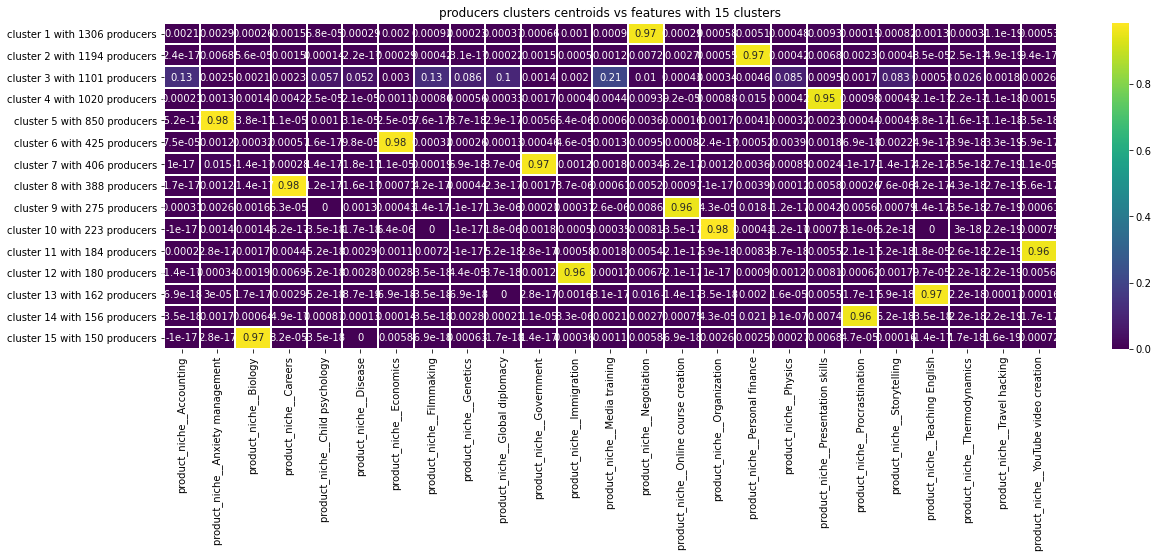

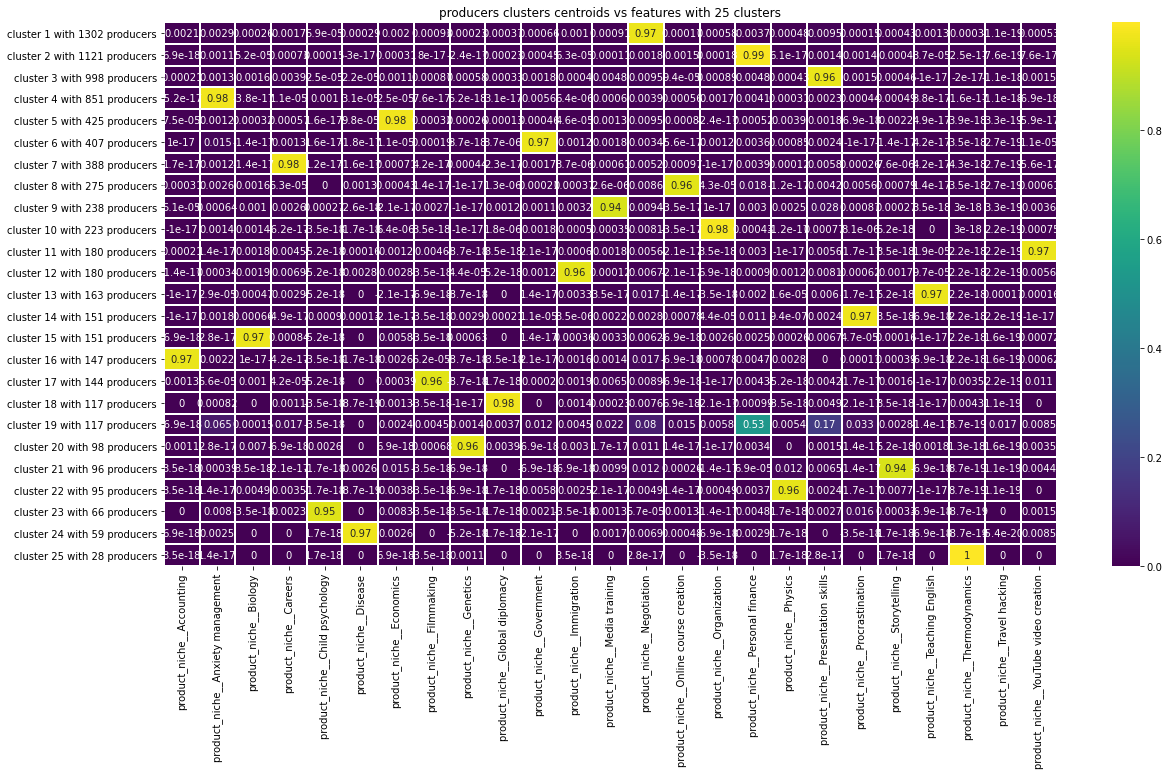

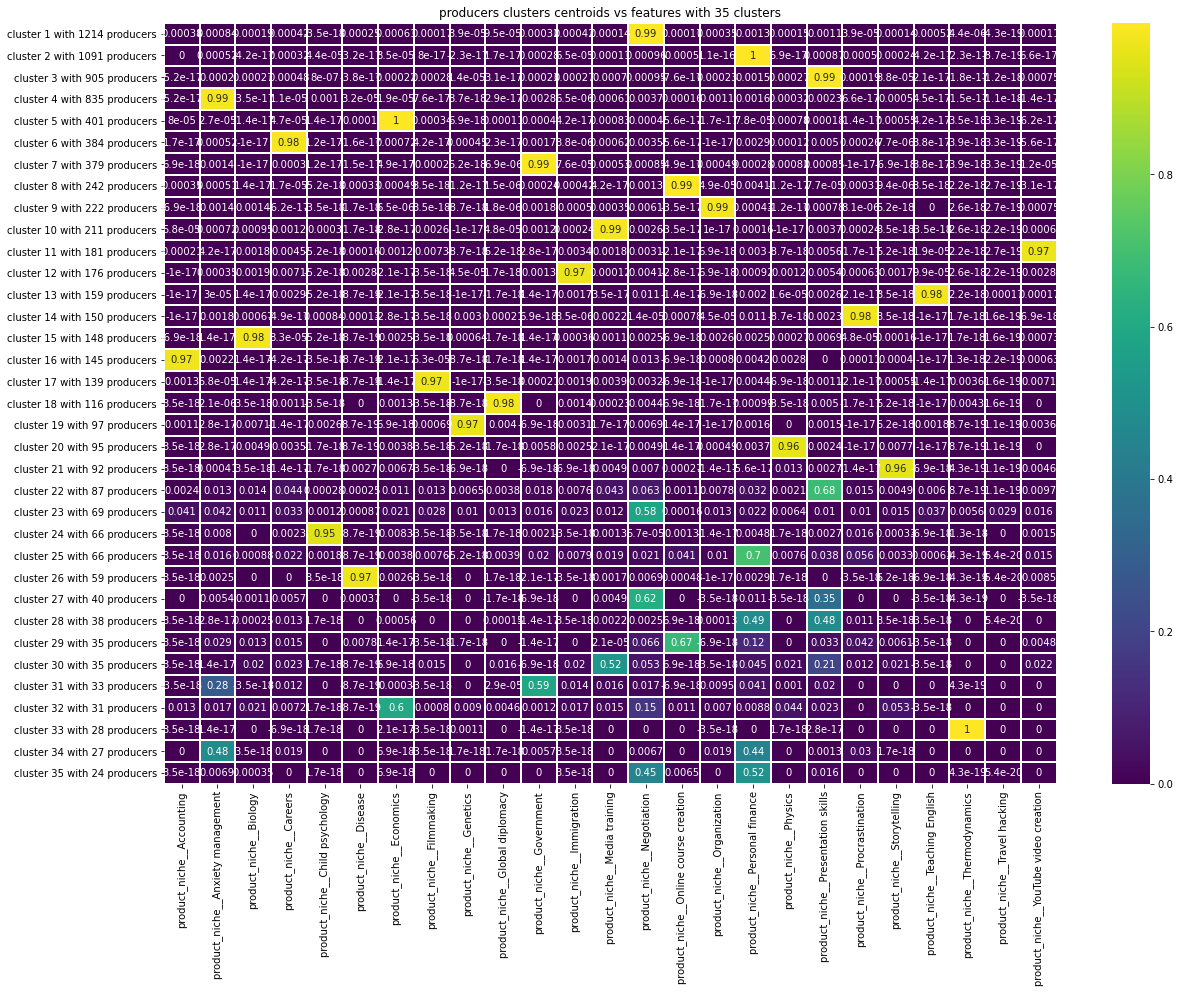

In [7]:
#computing and printing the clusters
for n_clusters in [15,25,35]:
    clusterize_with_heatmap(user_df_aggregated, n_clusters=n_clusters,  heatmap_figsize=(20,n_clusters//2.5 ), element_name='producers')

## 1.2) Clusters with Product Category

## Now we select product_category. This is also a categorical feature, so the same procedure that worked for "product_niche" will be employed, i.e, we clusterize with the distributions of product_category occuraces along each producer row

In [8]:
#same as was done for the categorical feature producer_niche, but now for the categorical feature product_category 

#reindexing the dataframe to turn it into producer-centered with "product_category" features
user_columns = ['product_category']
user_df = get_user_df(sales_df, user = ['producer_id'], columns_list=user_columns)

#getting one hot representation for the categorical features
categorical_columns = ['product_category']
user_df_one_hot= get_one_hot_user_df(user_df, columns_list = categorical_columns)

#summing the categorical features for different products sold by the same producer
user_df_aggregated = user_df_one_hot.groupby([user_df_one_hot.columns[0]]).sum()

#normalizing across columns to get a distribution of categories for each producer
user_df_aggregated = user_df_aggregated.div(user_df_aggregated.sum(axis=1), axis=0)

### Now we compute and plot the cluster heatmaps.

### This feature didn't work so well to find interesting clusters, since, as weas demonstrated with the GeneralStatistics notebook, most product sales were distributed across two major categories: podcast and phisical book. Here we can again see that kmeans tends to clusterize most users inside this two clusters. Its interesting to notice in the 5 clusters plot a cluster of 252 users that sell approximatelly 50% podcasts and 50% phisical books.

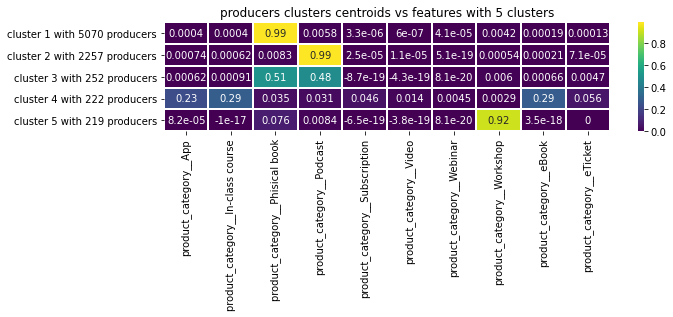

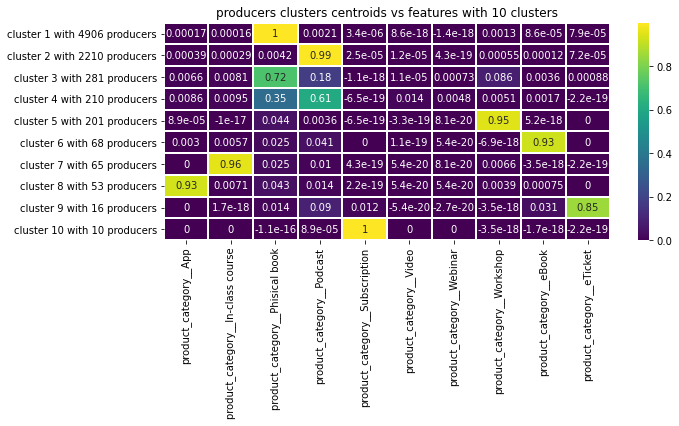

In [9]:
for n_clusters in [5,10]:
    clusterize_with_heatmap(user_df_aggregated, n_clusters=n_clusters,  heatmap_figsize=(10,n_clusters//2.5 ), element_name='producers')

## 1.3) Clusters with Product Category and Niche

### Can we find interesting clusterings by employing product_category and product_niche at the same time? Thats what we will try to find out. The procedure is similar to what was done above, except now we will have two distributions along each user row. We hope this will work with kmeans, since the distance values roughly mean the same thing and are also normalized. 

In [10]:
user_columns = ['product_niche', 'product_category']
user_df = get_user_df(sales_df, user = ['producer_id'], columns_list=user_columns)

#getting one hot representation for the categorical features
categorical_columns = ['product_niche', 'product_category']
user_df_one_hot= get_one_hot_user_df(user_df, columns_list = categorical_columns)

#summing the categorical features for different products sold by the same producer
user_df_aggregated = user_df_one_hot.groupby([user_df_one_hot.columns[0]]).sum()

#normalizing across columns to get a distribution of categories for each producer
#we multiply by 2 because now there are two distributions for each row, each one should sum up to 1
user_df_aggregated = user_df_aggregated.div(user_df_aggregated.sum(axis=1), axis=0)*2

### Now we compute and plot the cluster heatmaps.

### Notice that now, each row sums up to more than 1 and tends to sum up to 2. This is because the each of the 2 distributions along each row sums up to 1. 


### The most interesting clustering patterns occured with 35 clusters. We can see that the top clusters are still negotiation, presentation skills and personal finance and anxiety management, but they've been broken up along the product categories of phisical book and podcast.

### We've also find a workshop categorry that tends to correlate solely with the personal finance niche

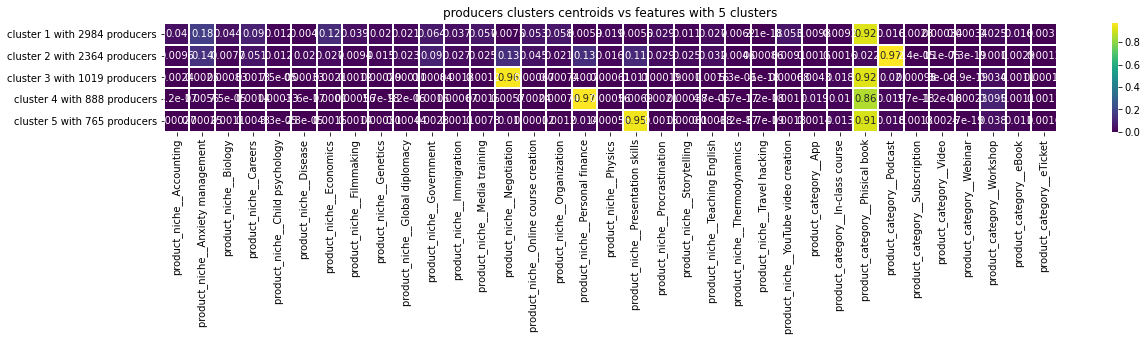

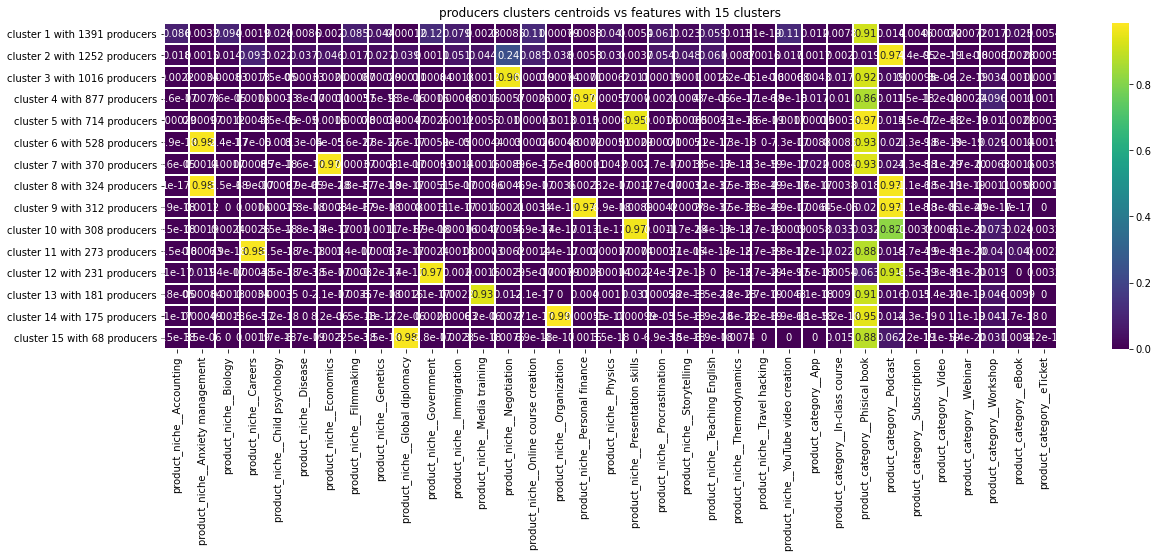

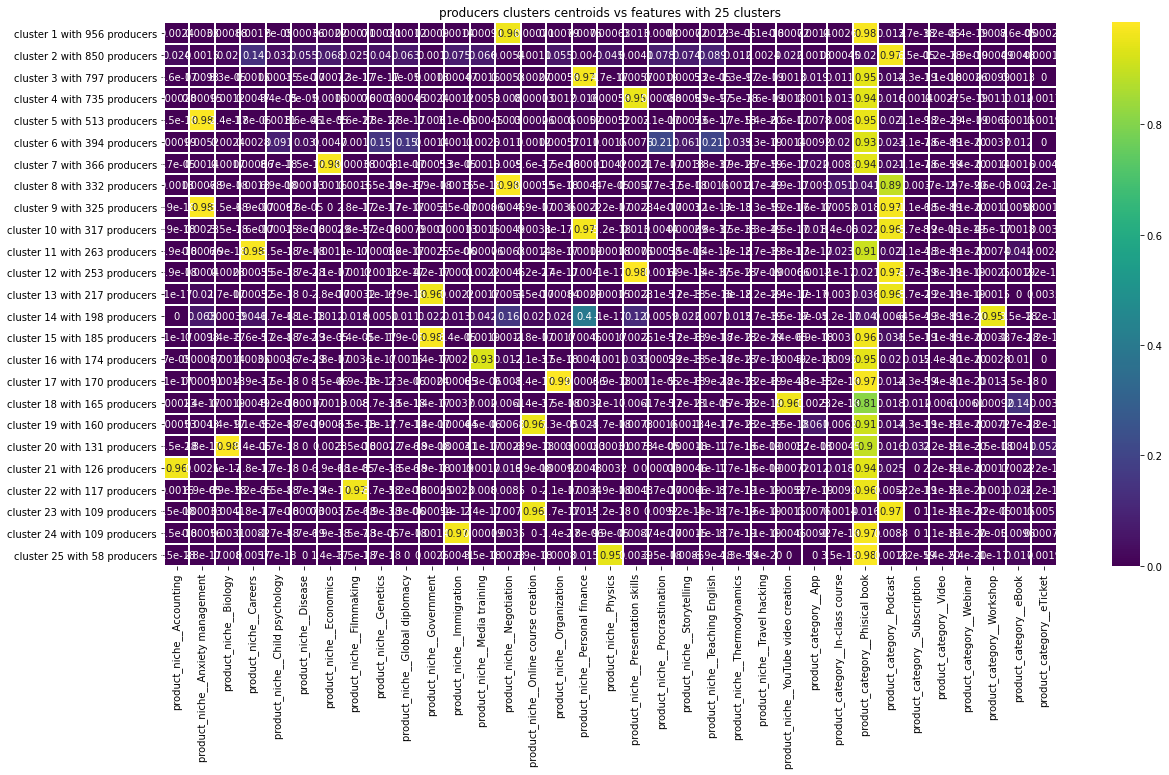

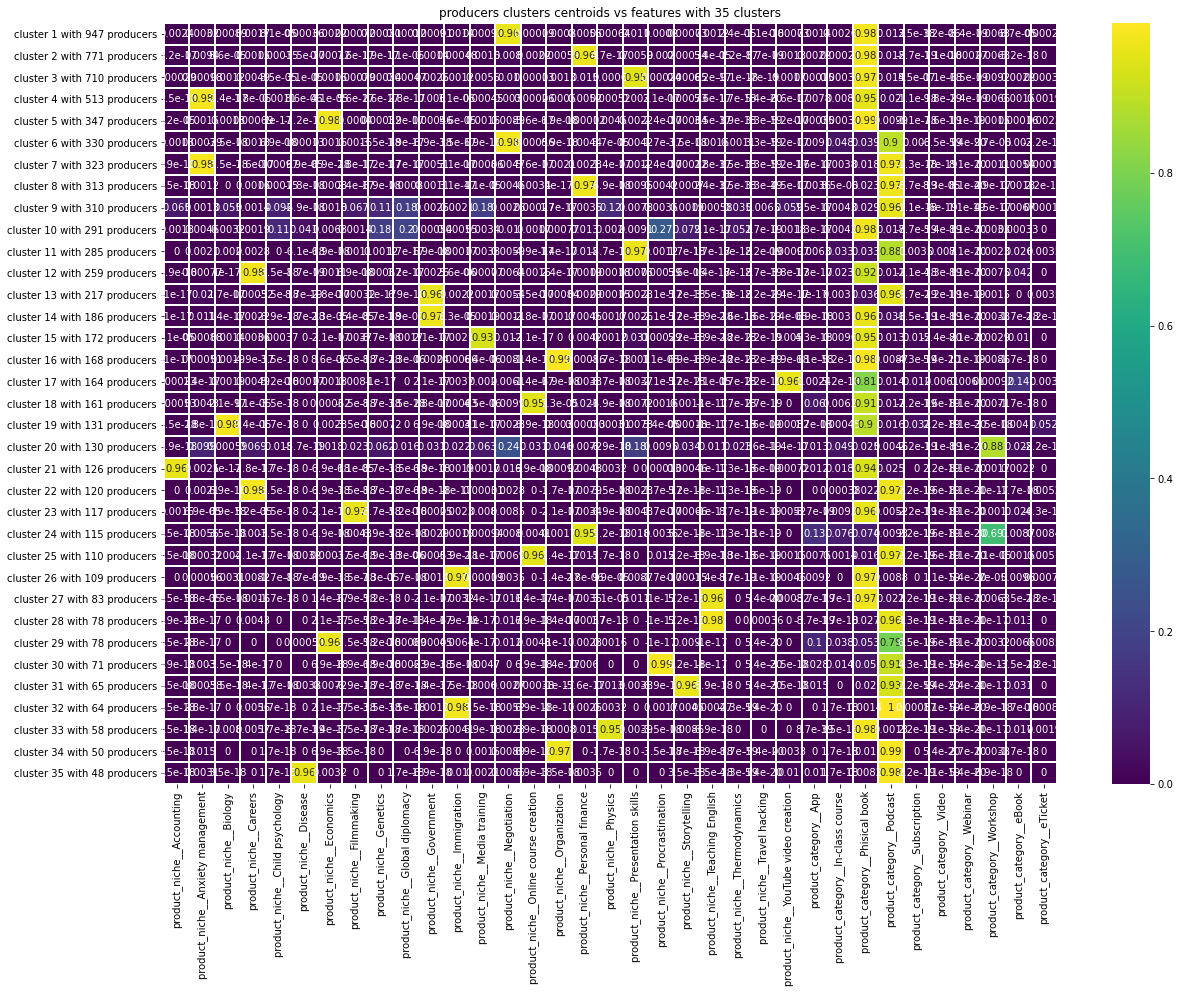

In [11]:
#computing and printing the clusters
for n_clusters in [5,15,25,35]:
    clusterize_with_heatmap(user_df_aggregated, n_clusters=n_clusters,  heatmap_figsize=(20,n_clusters//2.5 ), element_name='producers')

# 2) BUYER CLUSTER WITH PRODUCT DISTRIBUTION

### We will try to find clustering patterns for buyers, in the same manner as we did for producers

## 2.1) Clusters with Product Niche

In [19]:
#same as was done for producers and product niche, but now for buyers and product niche

#reindexing the dataframe to turn it into buyer-centered with "product_niche" features
user_columns = ['product_niche']
user_df = get_user_df(sales_df, user = ['buyer_id'], columns_list=user_columns)

#getting one hot representation for the categorical features
categorical_columns = ['product_niche']
user_df_one_hot= get_one_hot_user_df(user_df, columns_list = categorical_columns)

#summing the categorical features for different products bought by the same buyer
user_df_aggregated = user_df_one_hot.groupby([user_df_one_hot.columns[0]]).sum()

#normalizing across columns to get a distribution of categories for each buyer
user_df_aggregated = user_df_aggregated.div(user_df_aggregated.sum(axis=1), axis=0)

### Plotting the clusters heatmaps for product niche feature, we again notice the same prevalence for anxiety_management, negotiation, personal finance and presentation skills.

### Plotting the clusters heatmaps for product niche feature, we again notice the same prevalence for specific clusters of anxiety_management, negotiation, personal finance and presentation skills.

### for the plot of 35 clusters, we find some clusters with many aprox between 3K - 6K buyers, which exibit some  interesting correlations between gpurchases of certain niches. For instance, there's a cluster of 4510 buyers who purchese approximately 50% negotiation niche products and approx 50 %  personal finance niche products, which are conceputualy related niches. 

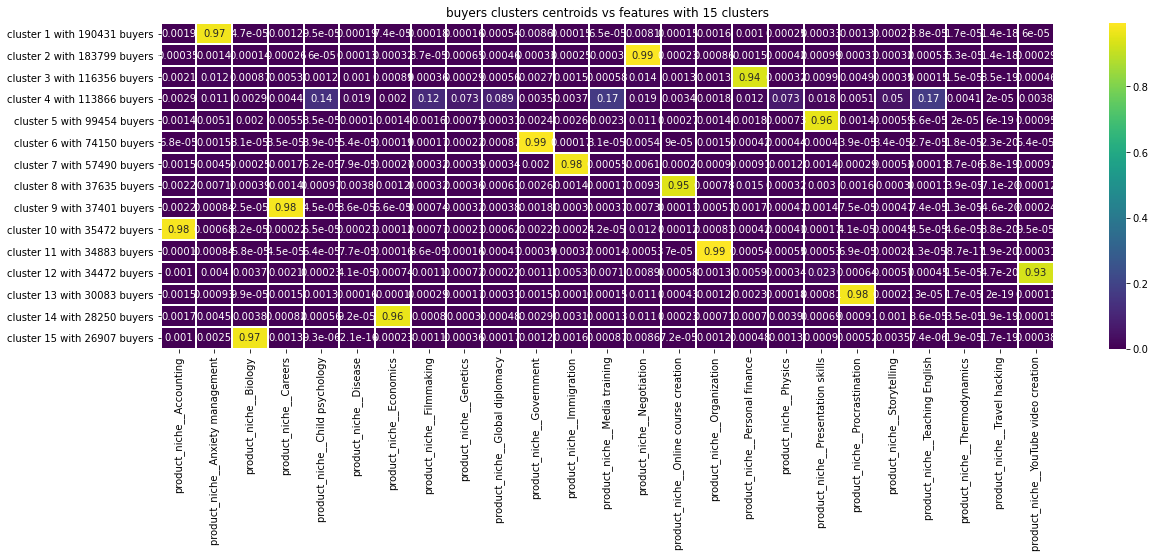

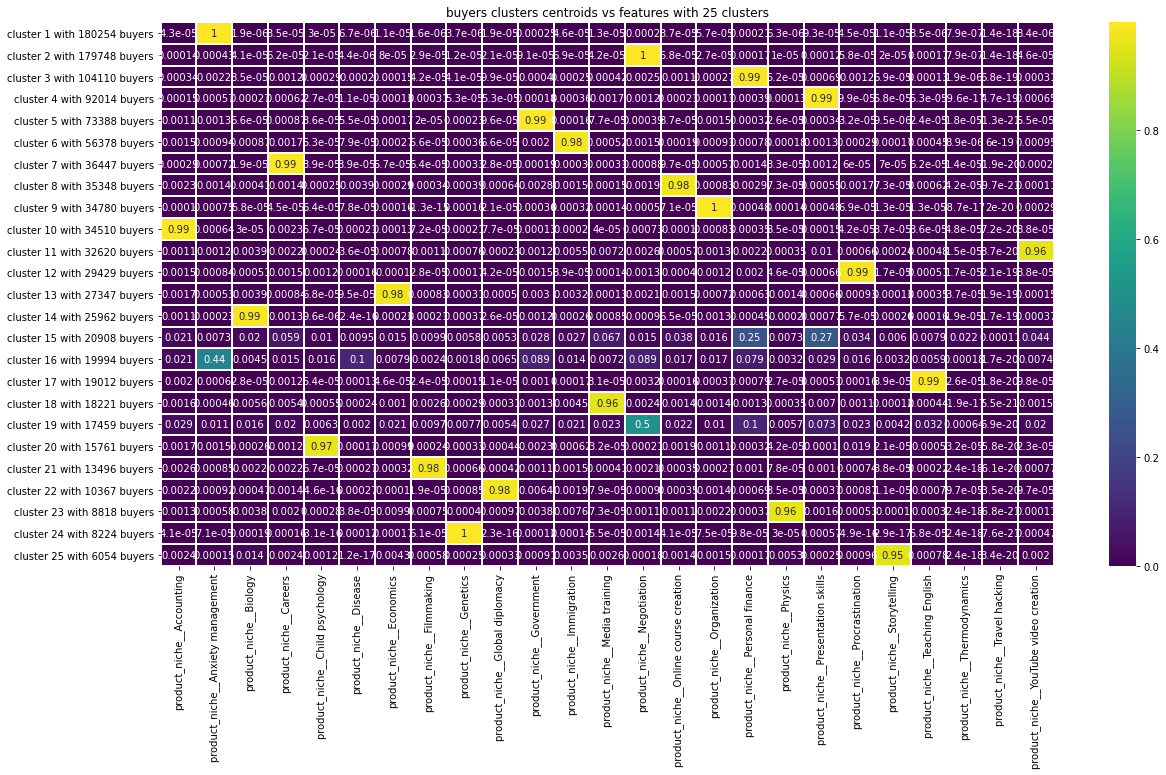

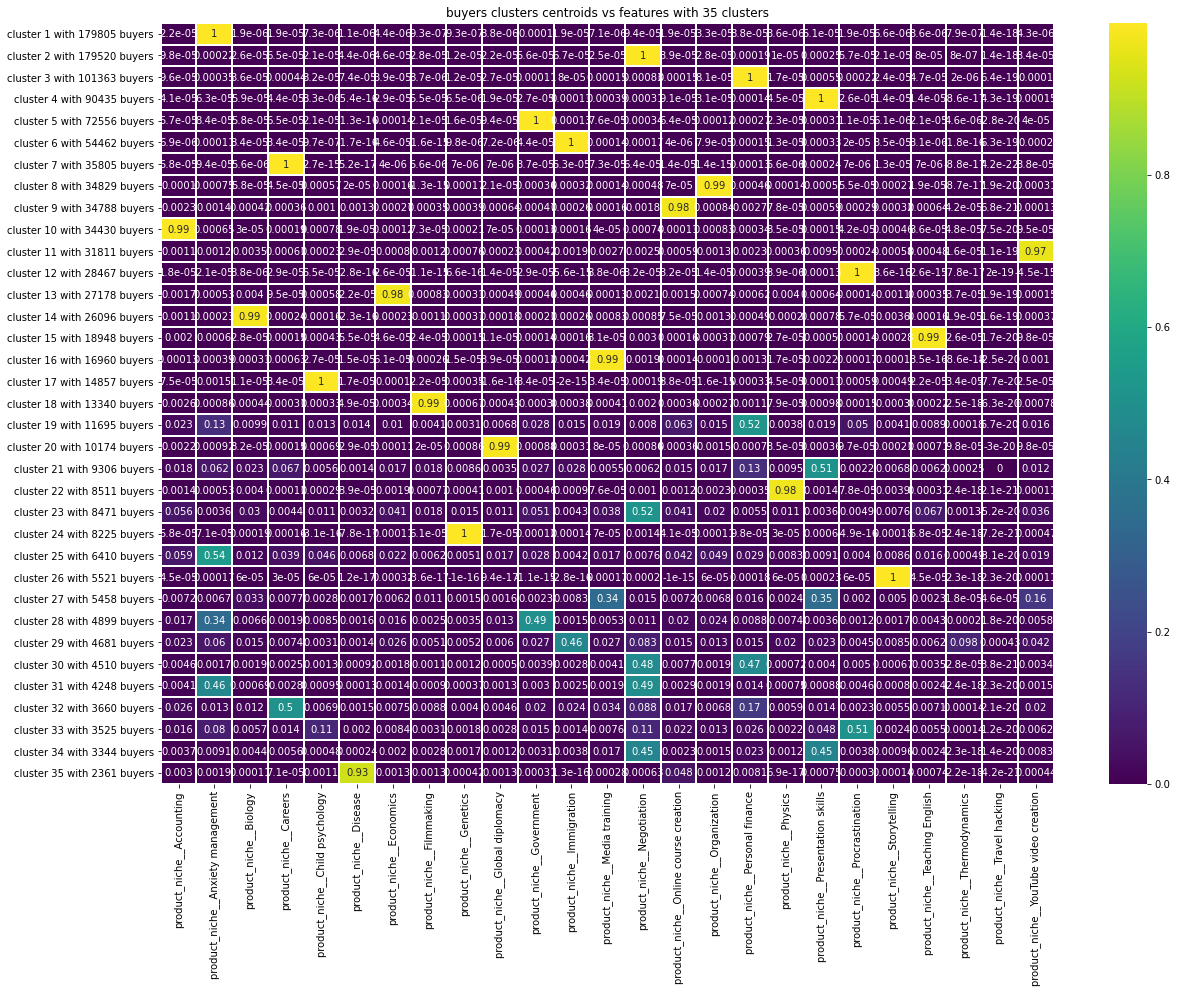

In [20]:
#printing the buyer clusters
for n_clusters in [15,25,35]:
    clusterize_with_heatmap(user_df_aggregated, n_clusters=n_clusters,  heatmap_figsize=(20,n_clusters//2.5 ), element_name='buyers')

## 2.2) Clusters with Product Category

In [21]:
#same as was done for producers and product_category, but now for buyers and product_category

#reindexing the dataframe to turn it into buyer-centered with "product_category" features
user_columns = ['product_category']
user_df = get_user_df(sales_df, user = ['buyer_id'], columns_list=user_columns)

#getting one hot representation for the categorical features
categorical_columns = ['product_category']
user_df_one_hot= get_one_hot_user_df(user_df, columns_list = categorical_columns)

#summing the categorical features for different products sold by the same buyer
user_df_aggregated = user_df_one_hot.groupby([user_df_one_hot.columns[0]]).sum()

#normalizing across columns to get a distribution of categories for each buyer
user_df_aggregated = user_df_aggregated.div(user_df_aggregated.sum(axis=1), axis=0)

### Plotting the clusters heatmaps for product niche category and buyers, we again notice the same concentration of clusters around podcast and phisical book. There's, however, a significant cluster of 27 k users who purchase 50% phisical books and 50 % podcasts.

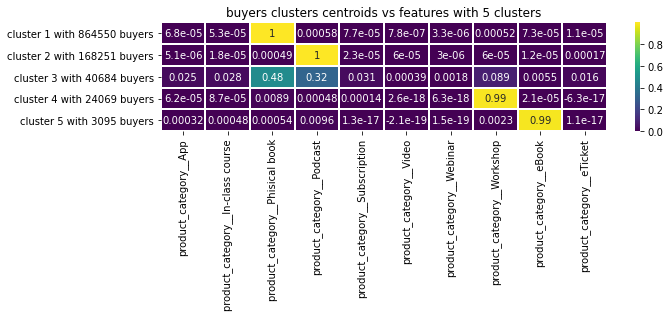

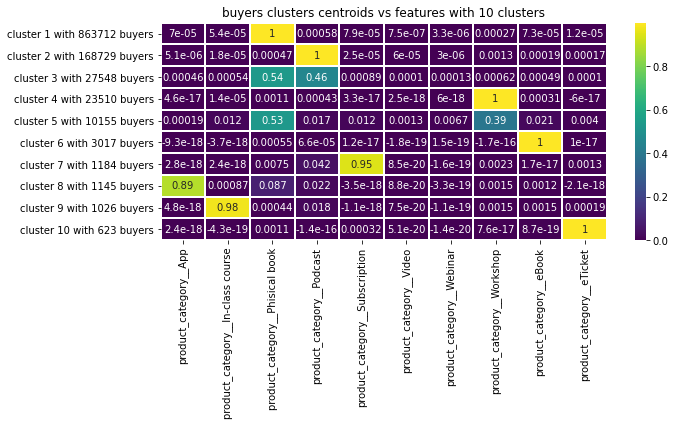

In [22]:
for n_clusters in [5,10]:
    clusterize_with_heatmap(user_df_aggregated, n_clusters=n_clusters,  heatmap_figsize=(10,n_clusters//2.5 ), element_name='buyers')

# 3) AFFILIATES CLUSTER WITH PRODUCT TYPE DISTRIBUTION

### We will try to find clustering patterns for affiliates, in the same manner as we did for producers and buyers

In [23]:
condition = sales_df['affiliate_commission_percentual']>0
affiliate_idxs = sales_df.index[condition]
sales_df_with_affiliate = sales_df.iloc()[affiliate_idxs]
sales_df_with_affiliate

purchase_id  product_id  affiliate_id  producer_id  buyer_id  \
0            1663958        6640        209372       116238   1200397   
1            1677087        2350        141418         2821   1083764   
3            2017379       57998       1164511        70388   1436118   
4            2017382       58329       1261488       221253   1386357   
5            2017387       17889        354805       192982   1274423   
...              ...         ...           ...          ...       ...   
1599815     14011978       83377       5781442      2307584   7701870   
1599817     14011987      187946       5588770      4235060   7486764   
1599819     14011991      182928       3475036      2038932   7701875   
1599821     14011993       85984         33980        34602   7701877   
1599822     14011994       46451       3321853        76908   7701848   

               purchase_date product_creation_date product_category  \
0        2016-06-26 12:00:00   2011-03-19 15:47:36            Video   
1        2016-06-26 12:00:00   2010-07-05 01:50:15          Podcast   
3        2016-06-26 12:00:00   2013-05-07 08:51:31          Podcast   
4        2016-06-26 12:00:00   2013-05-12 08:12:06          Podcast   
5        2016-06-26 12:00:00   2011-12-18 09:31:54    Phisical book   
...                      ...                   ...              ...   
1599815  2016-06-30 23:58:37   2014-01-24 19:46:59    Phisical book   
1599817  2016-06-30 23:59:06   2015-11-26 00:21:29          Podcast   
1599819  2016-06-30 23:59:31   2015-10-31 21:40:14    Phisical book   
1599821  2016-06-30 23:59:34   2014-02-17 14:15:23    Phisical book   
1599822  2016-06-30 23:59:45   2012-10-30 07:35:14          Podcast   

                  product_niche  purchase_value  \
0           Presentation skills       -0.265302   
1              Child psychology       -0.177077   
3            Anxiety management       -0.401168   
4              Teaching English       -0.452489   
5        Online course creation       -0.503716   
...                         ...             ...   
1599815      Anxiety management       -0.352326   
1599817            Organization       -0.272360   
1599819      Anxiety management        0.172069   
1599821      Anxiety management        0.742717   
1599822     Presentation skills       -0.485114   

         affiliate_commission_percentual purchase_device purchase_origin  \
0                                  50.00        Smart TV     Origin ef2b   
1                                  60.00        Smart TV     Origin ef2b   
3                                  50.00        Smart TV     Origin ef2b   
4                                  50.00        Smart TV     Origin ef2b   
5                                  58.85        Smart TV     Origin ef2b   
...                                  ...             ...             ...   
1599815                            60.00        eReaders     Origin 2d75   
1599817                            75.00         Desktop     Origin 8279   
1599819                            40.00        eReaders     Origin adf0   
1599821                            50.00         Desktop     Origin 7fd6   
1599822                            50.00        eReaders     Origin 54fd   

        is_origin_page_social_network  
0                                 0,0  
1                                 0,0  
3                                 0,0  
4                                 0,0  
5                                 0,0  
...                               ...  
1599815                           0,0  
1599817                           0,0  
1599819                           0,0  
1599821                           0,0  
1599822                           0,0  

[260974 rows x 14 columns]

## 3.1) Clusters with Product Niche

In [24]:
#reindexing the dataframe to turn it into affiliate-centered with "product_niche" features
user_columns = ['product_niche']
user_df = get_user_df(sales_df_with_affiliate, user = ['affiliate_id'], columns_list=user_columns)

#getting one hot representation for the categorical features
categorical_columns = ['product_niche']
user_df_one_hot= get_one_hot_user_df(user_df, columns_list = categorical_columns)

#summing the categorical features for different products sold by the same affiliate
user_df_aggregated = user_df_one_hot.groupby([user_df_one_hot.columns[0]]).sum()

#normalizing across columns to get a distribution of categories for each affiliate
user_df_aggregated = user_df_aggregated.div(user_df_aggregated.sum(axis=1), axis=0)

In [25]:
#result is a distribution of sales for each affiliate, with each row summing 1 across all categories

user_df_aggregated

product_niche__Accounting  product_niche__Anxiety management  \
affiliate_id                                                                 
59                                  0.0                           0.000000   
60                                  0.0                           0.000000   
62                                  0.0                           0.013423   
80                                  0.0                           0.000000   
83                                  0.0                           0.000000   
...                                 ...                                ...   
7678701                             1.0                           0.000000   
7678978                             0.0                           1.000000   
7683014                             0.0                           0.000000   
7689657                             0.0                           0.000000   
7700836                             0.0                           0.000000   

              product_niche__Biology  product_niche__Careers  \
affiliate_id                                                   
59                               0.0                0.000000   
60                               0.0                0.000000   
62                               0.0                0.006711   
80                               0.0                1.000000   
83                               0.0                0.000000   
...                              ...                     ...   
7678701                          0.0                0.000000   
7678978                          0.0                0.000000   
7683014                          0.0                0.000000   
7689657                          0.0                1.000000   
7700836                          0.0                1.000000   

              product_niche__Child psychology  product_niche__Disease  \
affiliate_id                                                            
59                                        0.0                     0.0   
60                                        0.0                     0.0   
62                                        0.0                     0.0   
80                                        0.0                     0.0   
83                                        0.0                     0.0   
...                                       ...                     ...   
7678701                                   0.0                     0.0   
7678978                                   0.0                     0.0   
7683014                                   0.0                     0.0   
7689657                                   0.0                     0.0   
7700836                                   0.0                     0.0   

              product_niche__Economics  product_niche__Filmmaking  \
affiliate_id                                                        
59                                 1.0                   0.000000   
60                                 0.0                   0.000000   
62                                 0.0                   0.328859   
80                                 0.0                   0.000000   
83                                 0.0                   0.000000   
...                                ...                        ...   
7678701                            0.0                   0.000000   
7678978                            0.0                   0.000000   
7683014                            0.0                   0.000000   
7689657                            0.0                   0.000000   
7700836                            0.0                   0.000000   

              product_niche__Genetics  product_niche__Global diplomacy  ...  \
affiliate_id                                                            ...   
59                                0.0                              0.0  ...   
60                                0.0                              0.0  ...   
62

### Plotting the clusters heatmaps for product niche feature, we again notice the same prevalence for anxiety_management, negotiation, personal finance and presentation skills. But now, interestingly, goverment is among the top 4 niches with most elements for the clusterings with more than 15 K-Means. 

### the most prevalent clusters tend to correlate with only one product niches, but we can notice a wide range of mixed distributions for the clusters in the range of 100-250 in the 45 Kmeans clustering.

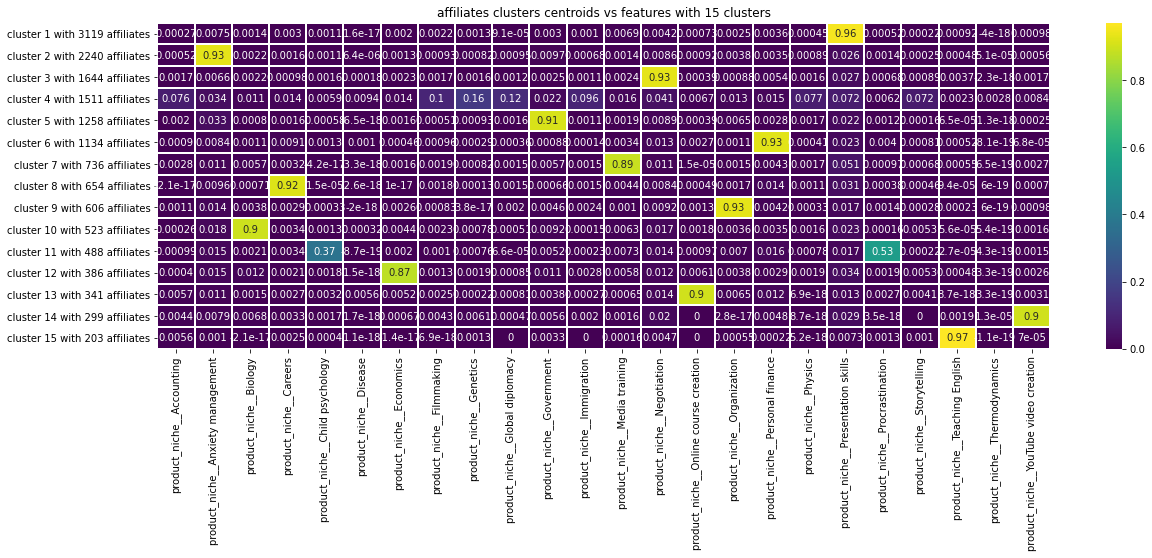

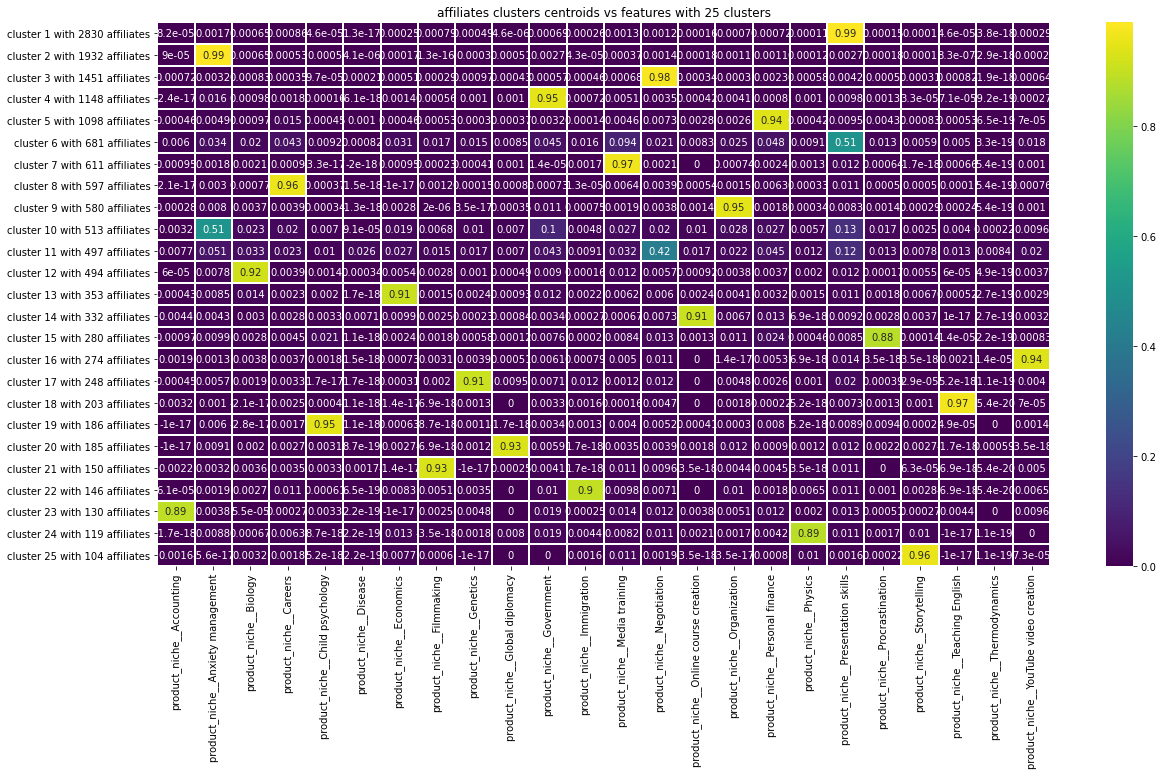

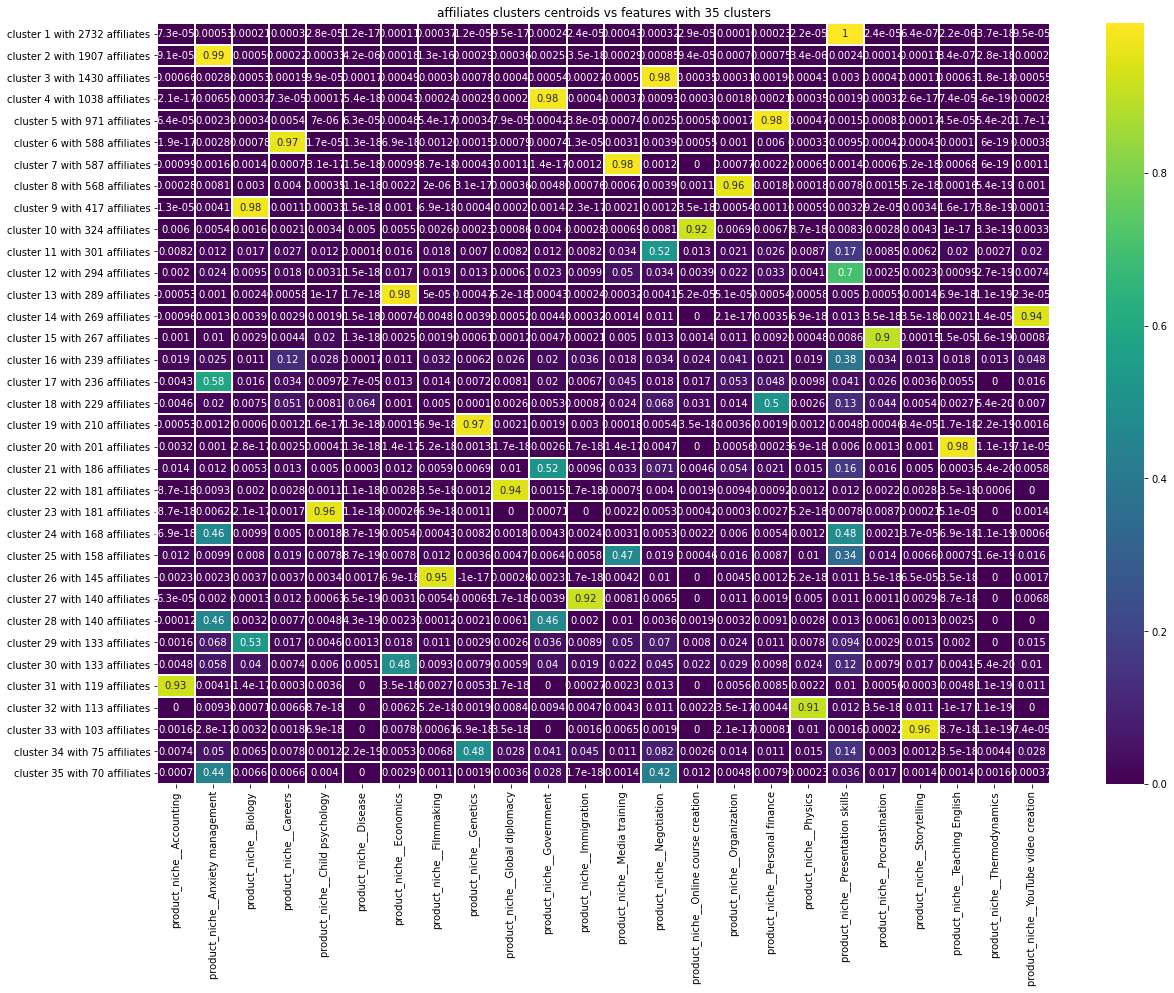

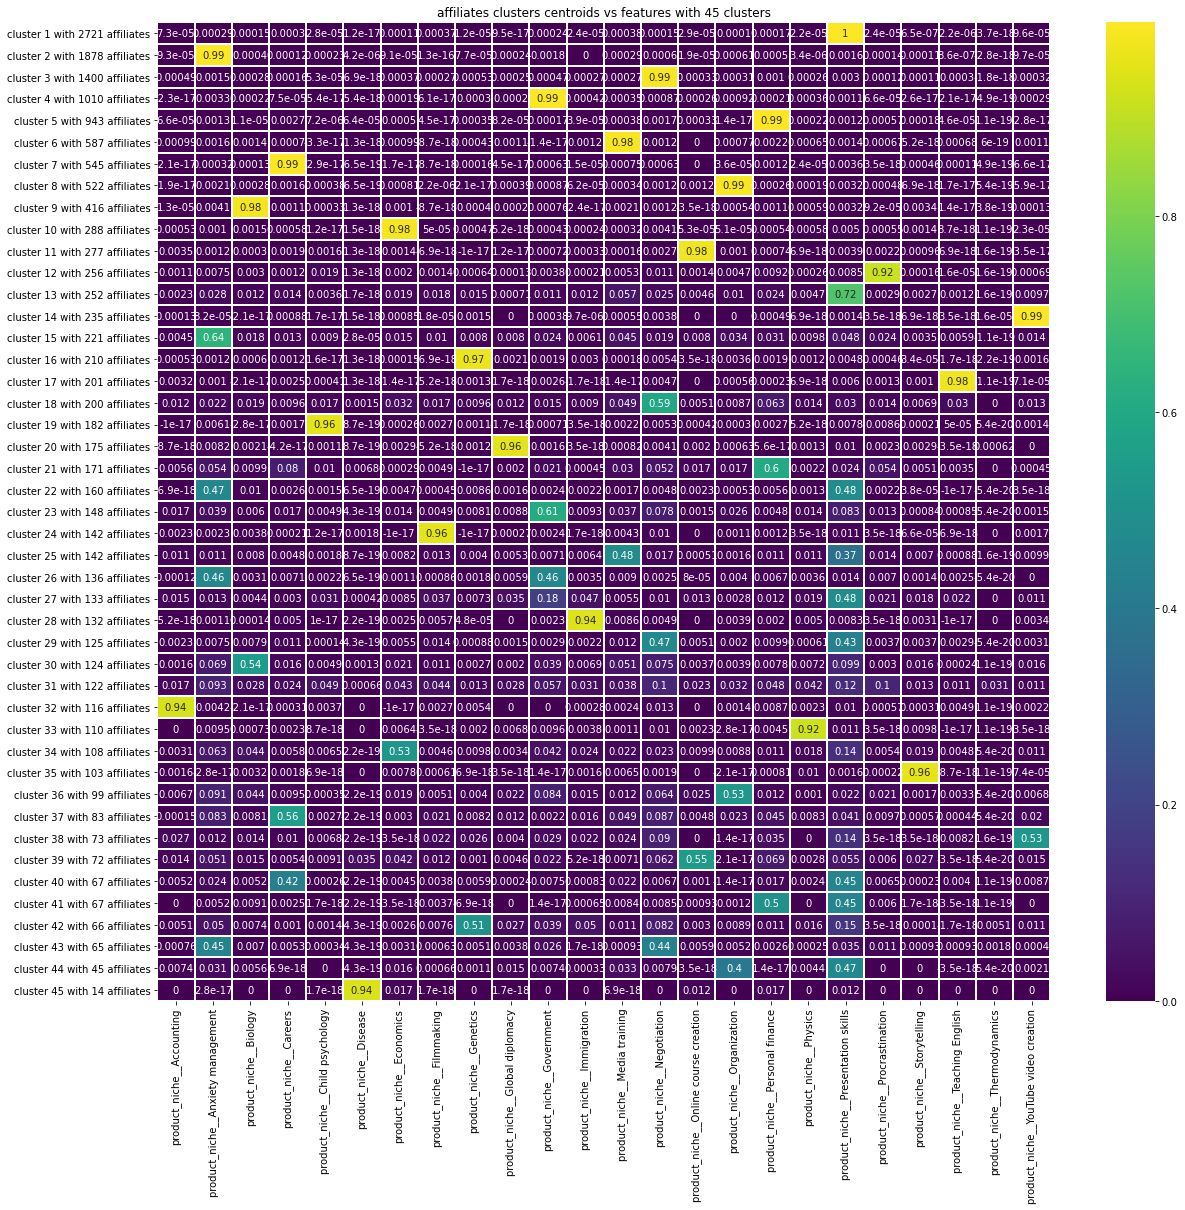

In [26]:
#computing and printing the clusters
for n_clusters in [15,25,35,45]:
    clusterize_with_heatmap(user_df_aggregated, n_clusters=n_clusters,  heatmap_figsize=(20,n_clusters//2.5 ), element_name='affiliates')

## 3.2) Clusters with Product Category

In [27]:
#same as was done for producers and product_category, but now for affiliate and product_category

#reindexing the dataframe to turn it into affiliate-centered with "product_category" features
user_columns = ['product_category']
user_df = get_user_df(sales_df_with_affiliate, user = ['affiliate_id'], columns_list=user_columns)

#getting one hot representation for the categorical features
categorical_columns = ['product_category']
user_df_one_hot= get_one_hot_user_df(user_df, columns_list = categorical_columns)

#summing the categorical features for different products sold by the same affiliate
user_df_aggregated = user_df_one_hot.groupby([user_df_one_hot.columns[0]]).sum()

#normalizing across columns to get a distribution of categories for each affiliate
user_df_aggregated = user_df_aggregated.div(user_df_aggregated.sum(axis=1), axis=0)

### Plotting the clusters heatmaps for product category feature and affiliates, we again notice a concentration in phisical book and podcasts categories, and,  in similar manner as the buyer clustering, come significant clusters of affiliates with mixed distributions across phisical book and podcasts.

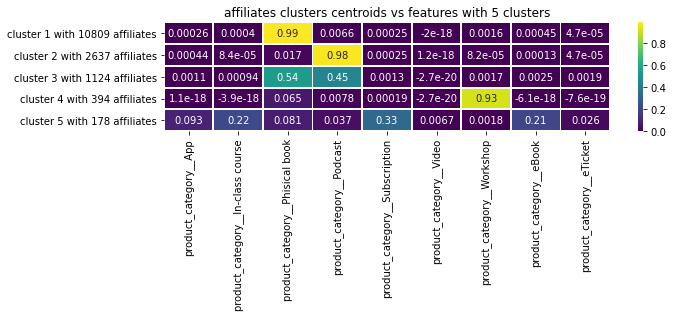

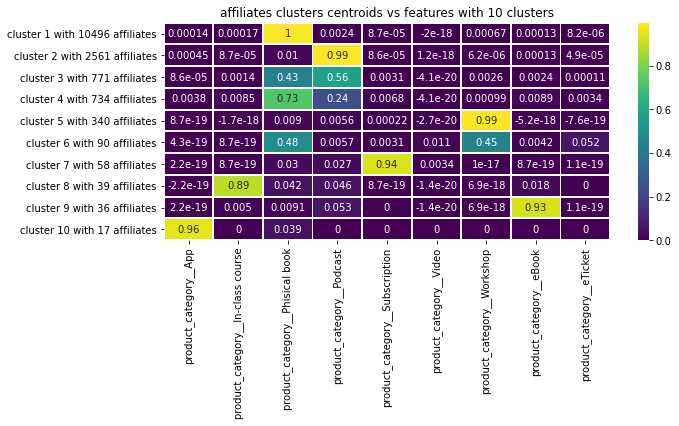

In [28]:
for n_clusters in [5,10]:
    clusterize_with_heatmap(user_df_aggregated, n_clusters=n_clusters,  heatmap_figsize=(10,n_clusters//2.5 ), element_name='affiliates')

# 4) FAILED ATTEMPT: PRODUCER CLUSTER WITH STANDARDIZED PRODUCT NICHE COUNTS

### Here we briefly report an attempt to use standardized features across the aggregated one hot represented columns, insted of adpting the distribution across rows used in the previous clusters. 

In [29]:
#reindexing the dataframe to turn it into producer-centered with "product_niche" features
user_columns = ['product_niche']
user_df = get_user_df(sales_df, user = ['producer_id'], columns_list=user_columns)

#getting one hot representation for the categorical features
categorical_columns = ['product_niche']
user_df_one_hot= get_one_hot_user_df(user_df, columns_list = categorical_columns)

#summing the categorical features for different products sold by the same affiliate
user_df_aggregated = user_df_one_hot.groupby([user_df_one_hot.columns[0]]).sum()

### This the dataframe of aggregated one hot features for the product_niche categorical feature. Here we can see that we no long have a distribution summing up to 1, but a count of occurances for each type of produc_niche for each producer, which is obtained by aggregating the one hot representations of multiple products of each user

In [30]:
user_df_aggregated

product_niche__Accounting  product_niche__Anxiety management  \
producer_id                                                                 
3                                  0.0                                0.0   
59                                 0.0                                1.0   
60                                 0.0                                0.0   
80                                 0.0                                0.0   
93                                 0.0                                0.0   
...                                ...                                ...   
7623443                            0.0                                0.0   
7626841                            0.0                                0.0   
7630136                            0.0                                1.0   
7631606                            0.0                                0.0   
9868481                            0.0                                0.0   

             product_niche__Biology  product_niche__Careers  \
producer_id                                                   
3                               0.0                     0.0   
59                              0.0                     0.0   
60                              0.0                     0.0   
80                              0.0                   489.0   
93                              0.0                     0.0   
...                             ...                     ...   
7623443                         0.0                     0.0   
7626841                         0.0                     0.0   
7630136                         0.0                     0.0   
7631606                         0.0                     1.0   
9868481                         0.0                     0.0   

             product_niche__Child psychology  product_niche__Disease  \
producer_id                                                            
3                                        0.0                     2.0   
59                                       0.0                     0.0   
60                                       0.0                     0.0   
80                                       0.0                     0.0   
93                                       0.0                     0.0   
...                                      ...                     ...   
7623443                                  0.0                     0.0   
7626841                                  0.0                     0.0   
7630136                                  0.0                     0.0   
7631606                                  0.0                     0.0   
9868481                                  0.0                     0.0   

             product_niche__Economics  product_niche__Filmmaking  \
producer_id                                                        
3                                 0.0                        0.0   
59                                0.0                        0.0   
60                                0.0                        0.0   
80                                0.0                        0.0   
93                                0.0                        2.0   
...                               ...                        ...   
7623443                           5.0                        0.0   
7626841                           0.0                        0.0   
7630136                           0.0                        0.0   
7631606                           0.0                        0.0   
9868481                           0.0                        0.0   

             product_niche__Genetics  product_niche__Global diplomacy  ...  \
producer_id                                                            ...   
3                                0.0                              0.0  ...   
59                               0.0                              0.0  ...   
60                               0.0                     

### We then perform the standardization across columns by subtracting the mean and than dividing the result by the standard deviation=sqrt(var)

In [31]:
var = user_df_aggregated.var(axis=0)
mean = user_df_aggregated.mean(axis=0)*-1
user_df_aggregated_stdd = user_df_aggregated
user_df_aggregated_stdd = user_df_aggregated_stdd.add(user_df_aggregated_stdd.mean(axis=0)*-1, axis=1)
user_df_aggregated_stdd = user_df_aggregated_stdd.div(np.sqrt(var), axis=1)

### As expected, we get mean zero across each columns...

In [32]:
user_df_aggregated_stdd.mean(axis=0)

product_niche__Accounting               -4.872799e-18
product_niche__Anxiety management        1.063156e-17
product_niche__Biology                  -1.771927e-18
product_niche__Careers                  -5.315781e-18
product_niche__Child psychology          8.859635e-19
product_niche__Disease                  -8.859635e-18
product_niche__Economics                -3.543854e-18
product_niche__Filmmaking                1.594734e-17
product_niche__Genetics                  2.879381e-18
product_niche__Global diplomacy         -1.771927e-18
product_niche__Government                8.748890e-18
product_niche__Immigration               8.859635e-19
product_niche__Media training           -1.949120e-17
product_niche__Negotiation               5.315781e-18
product_niche__Online course creation   -7.087708e-18
product_niche__Organization             -1.771927e-18
product_niche__Personal finance          7.087708e-18
product_niche__Physics                   7.973672e-18
product_niche__Presentation 

### As expected, we variance 1, which is equivalent to std of 1

In [33]:
user_df_aggregated_stdd.var(axis=0)

product_niche__Accounting                1.0
product_niche__Anxiety management        1.0
product_niche__Biology                   1.0
product_niche__Careers                   1.0
product_niche__Child psychology          1.0
product_niche__Disease                   1.0
product_niche__Economics                 1.0
product_niche__Filmmaking                1.0
product_niche__Genetics                  1.0
product_niche__Global diplomacy          1.0
product_niche__Government                1.0
product_niche__Immigration               1.0
product_niche__Media training            1.0
product_niche__Negotiation               1.0
product_niche__Online course creation    1.0
product_niche__Organization              1.0
product_niche__Personal finance          1.0
product_niche__Physics                   1.0
product_niche__Presentation skills       1.0
product_niche__Procrastination           1.0
product_niche__Storytelling              1.0
product_niche__Teaching English          1.0
product_ni

### Here is the standardized data frame

In [34]:
user_df_aggregated_stdd

product_niche__Accounting  product_niche__Anxiety management  \
producer_id                                                                 
3                            -0.033567                          -0.058077   
59                           -0.033567                          -0.056226   
60                           -0.033567                          -0.058077   
80                           -0.033567                          -0.058077   
93                           -0.033567                          -0.058077   
...                                ...                                ...   
7623443                      -0.033567                          -0.058077   
7626841                      -0.033567                          -0.058077   
7630136                      -0.033567                          -0.056226   
7631606                      -0.033567                          -0.058077   
9868481                      -0.033567                          -0.058077   

             product_niche__Biology  product_niche__Careers  \
producer_id                                                   
3                          -0.03304               -0.062224   
59                         -0.03304               -0.062224   
60                         -0.03304               -0.062224   
80                         -0.03304                4.548304   
93                         -0.03304               -0.062224   
...                             ...                     ...   
7623443                    -0.03304               -0.062224   
7626841                    -0.03304               -0.062224   
7630136                    -0.03304               -0.062224   
7631606                    -0.03304               -0.052796   
9868481                    -0.03304               -0.062224   

             product_niche__Child psychology  product_niche__Disease  \
producer_id                                                            
3                                  -0.028361                0.041628   
59                                 -0.028361               -0.014643   
60                                 -0.028361               -0.014643   
80                                 -0.028361               -0.014643   
93                                 -0.028361               -0.014643   
...                                      ...                     ...   
7623443                            -0.028361               -0.014643   
7626841                            -0.028361               -0.014643   
7630136                            -0.028361               -0.014643   
7631606                            -0.028361               -0.014643   
9868481                            -0.028361               -0.014643   

             product_niche__Economics  product_niche__Filmmaking  \
producer_id                                                        
3                           -0.082499                  -0.034457   
59                          -0.082499                  -0.034457   
60                          -0.082499                  -0.034457   
80                          -0.082499                  -0.034457   
93                          -0.082499                  -0.008509   
...                               ...                        ...   
7623443                     -0.000554                  -0.034457   
7626841                     -0.082499                  -0.034457   
7630136                     -0.082499                  -0.034457   
7631606                     -0.082499                  -0.034457   
9868481                     -0.082499                  -0.034457   

             product_niche__Genetics  product_niche__Global diplomacy  ...  \
producer_id                                                            ...   
3                          -0.040448                         -0.02964  ...   
59                         -0.040448                         -0.02964  ...   
60                         -0.040448                     

### Now we plot the clusters for different n clusters selections. As we can see, the most elements get concentrated around a centroid that is roughly zero across all dimentions. The remeinder of clusters get very few elements, and they are only formed because the value of along each categorical feature for these elements is way higher than the average, even with standardization, and kmeans is too sensitive to these variations. It is the case also that we are no longer filtering the number of sales by each user, which could only be done by normalizing each across each row. So the users with most sales get a result way higher than average, which interfers with the clustering information in regards to which kind of features each user is mostly related to, i.e, the clustering gets way more sensitive to number of sales rather than their distribution. 

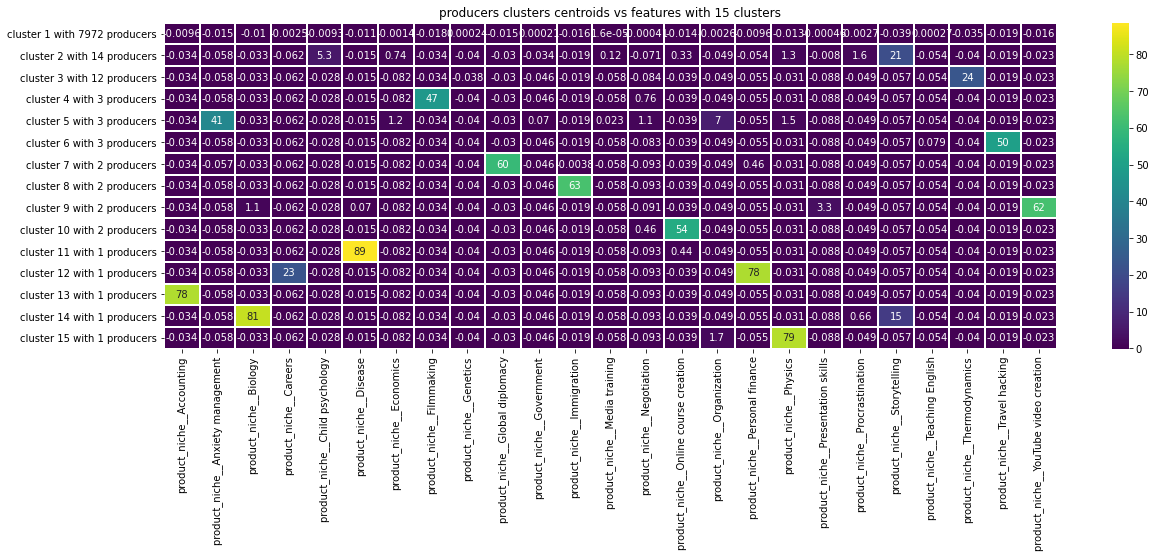

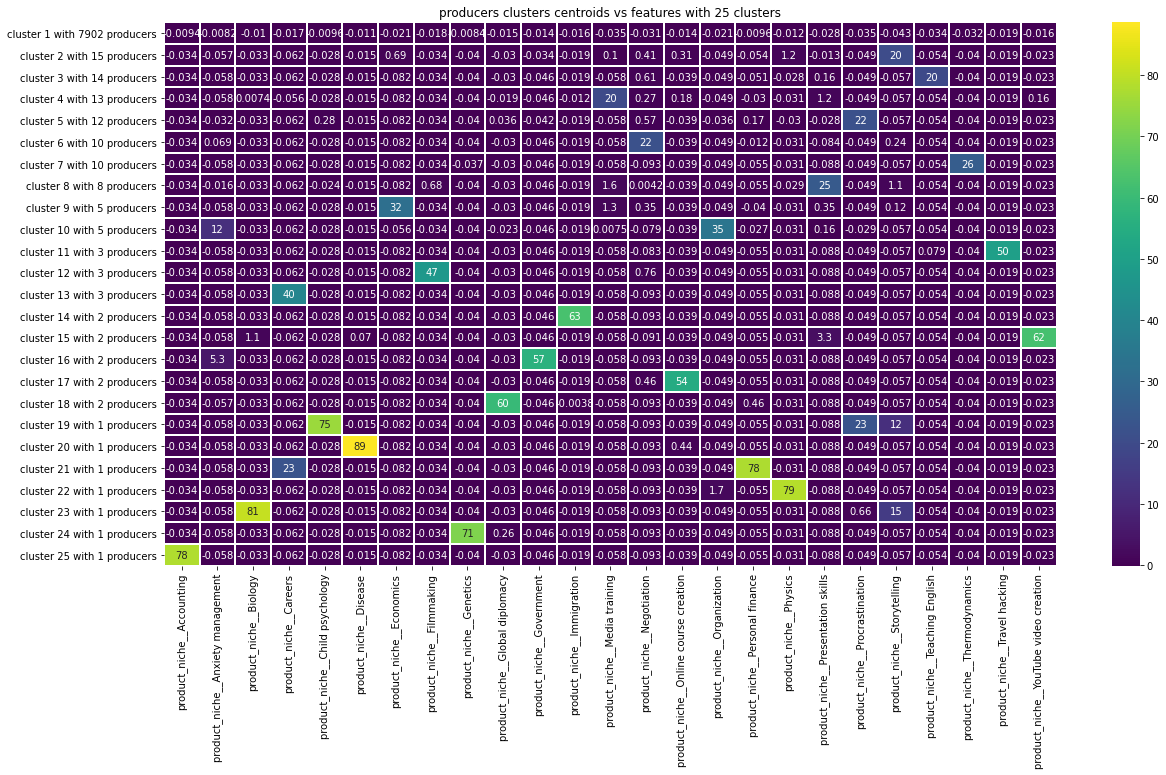

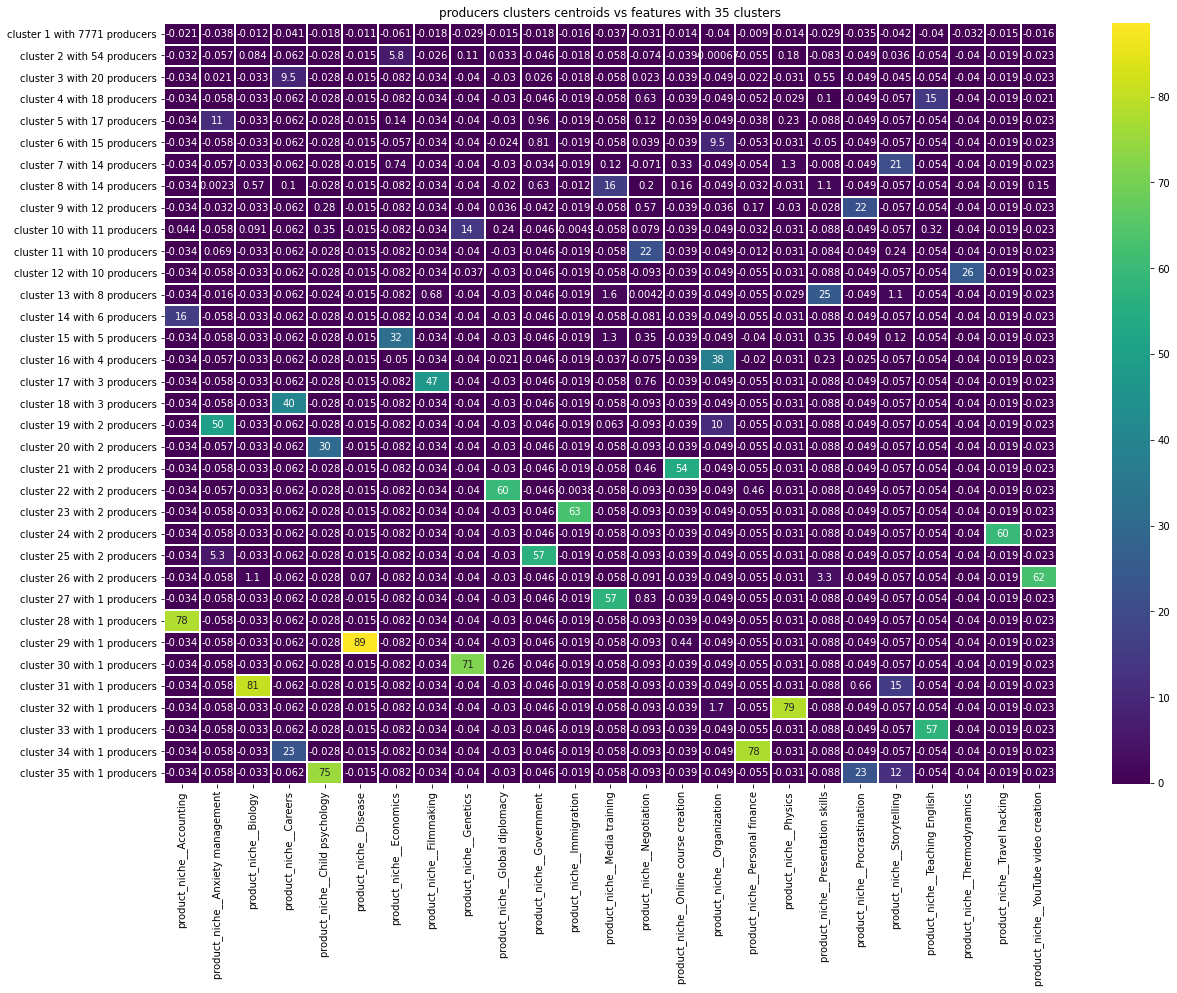

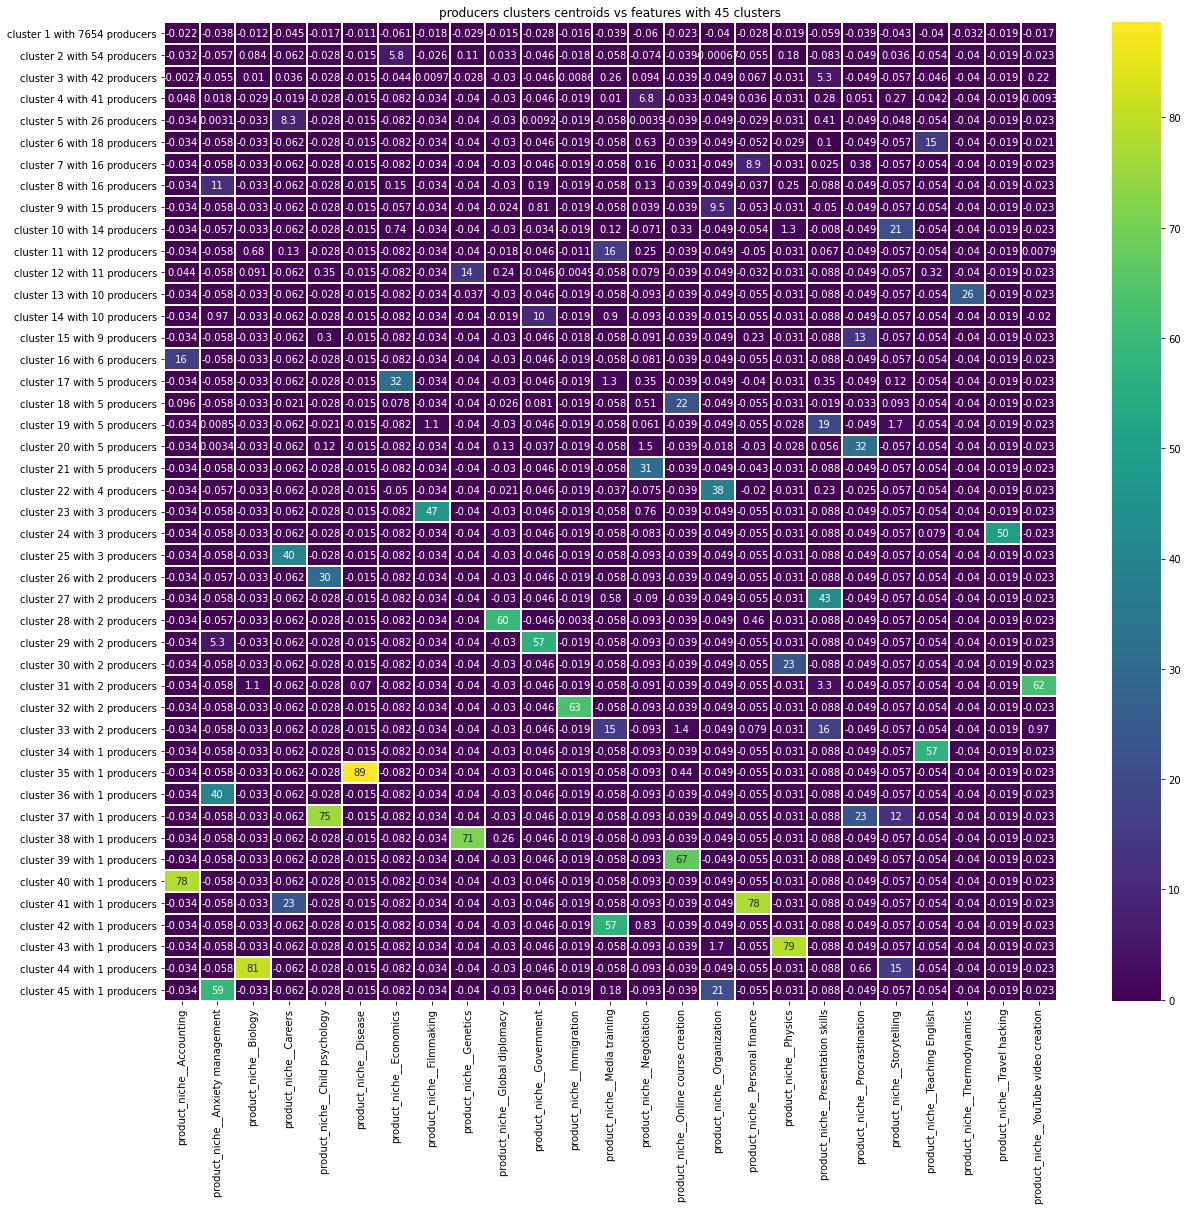

In [35]:
#computing and printing the clusters
for n_clusters in [15,25,35,45]:
    clusterize_with_heatmap(user_df_aggregated_stdd, n_clusters=n_clusters,  heatmap_figsize=(20,n_clusters//2.5 ), element_name='producers')